# **STARTING EVERYTHING AGAIN <br>(Take 7)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reszing to 512x512**

In [ ]:
import os
from PIL import Image

src = "/content/drive/MyDrive/Gen AI Project/cartoonset10k/"
dst = "/content/drive/MyDrive/Gen AI Project/cartoonset512/"  # output
os.makedirs(dst, exist_ok=True)

for file in os.listdir(src):
    if file.endswith(".png"):
        img = Image.open(os.path.join(src, file)).convert("RGB")
        img = img.resize((512, 512))
        img.save(os.path.join(dst, file))

print("Done resizing!")
"/content/drive/MyDrive/Gen AI Project/cartoonset10k/"


Done resizing!


'/content/drive/MyDrive/Gen AI Project/cartoonset10k/'

# **libraries and versions**

In [ ]:
# 1. Uninstall potential conflicts
!pip uninstall -y torch torchvision diffusers transformers accelerate peft

# 2. Install Stable Versions
!pip install -q -U torch torchvision --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U diffusers transformers accelerate peft bitsandbytes scipy safetensors

Found existing installation: torch 2.9.0+cu126
Uninstalling torch-2.9.0+cu126:
  Successfully uninstalled torch-2.9.0+cu126
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: diffusers 0.29.2
Uninstalling diffusers-0.29.2:
  Successfully uninstalled diffusers-0.29.2
Found existing installation: transformers 4.39.3
Uninstalling transformers-4.39.3:
  Successfully uninstalled transformers-4.39.3
Found existing installation: accelerate 1.1.0
Uninstalling accelerate-1.1.0:
  Successfully uninstalled accelerate-1.1.0
Found existing installation: peft 0.11.1
Uninstalling peft-0.11.1:
  Successfully uninstalled peft-0.11.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.4/780.4 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 90.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━

# **Creating Captions**

In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/Gen AI Project/cartoonset512/"
OUTPUT_PATH = "/content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500/"

os.makedirs(OUTPUT_PATH, exist_ok=True)

def describe_image(filename):
    # Extract attributes encoded in the filename
    # Example filename: "cs12345.png"
    # This is a placeholder example captioning logic:
    return "a cartoon character with unique facial attributes"

count = 0
for file in os.listdir(DATASET_PATH):
    if file.endswith(".png"):
        img_path = os.path.join(DATASET_PATH, file)

        caption = describe_image(file)

        # Save image
        os.system(f'cp "{img_path}" "{OUTPUT_PATH}/{file}"')

        # Save caption text file
        txt_name = file.replace(".png", ".txt")
        with open(os.path.join(OUTPUT_PATH, txt_name), "w") as f:
            f.write(caption)

        count += 1
        if count >= 1500:
            break

print("Done generating captions for 1500 images!")


# **text to image file**

In [ ]:
# Download the script specifically for diffusers v0.35.2
!wget -O train_text_to_image_lora.py https://raw.githubusercontent.com/huggingface/diffusers/v0.35.2/examples/text_to_image/train_text_to_image_lora.py

--2025-11-24 20:29:49--  https://raw.githubusercontent.com/huggingface/diffusers/v0.35.2/examples/text_to_image/train_text_to_image_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41271 (40K) [text/plain]
Saving to: ‘train_text_to_image_lora.py’

train_text_to_image 100%[===================>]  40.30K  --.-KB/s    in 0.006s  

2025-11-24 20:29:49 (6.99 MB/s) - ‘train_text_to_image_lora.py’ saved [41271/41271]



# **Generating MetaData.jsonl for cartoonset_captioned_1500**

In [ ]:
import os
import json

# ⚠️ UPDATE THIS PATH to your folder with 1500 images and .txt files
DATA_DIR = "/content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500"

# Output file
METADATA_FILE = os.path.join(DATA_DIR, "metadata.jsonl")

print(f"--- Generating metadata for {DATA_DIR} ---")

entries = []
missing_txt = 0

# Loop through all files
for filename in os.listdir(DATA_DIR):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct expected text filename
        txt_filename = os.path.splitext(filename)[0] + ".txt"
        txt_path = os.path.join(DATA_DIR, txt_filename)

        if os.path.exists(txt_path):
            # Read the caption
            with open(txt_path, 'r') as f:
                caption = f.read().strip()

            # Add to list
            entries.append({
                "file_name": filename,
                "text": caption
            })
        else:
            missing_txt += 1

# Write the JSONL file
with open(METADATA_FILE, 'w') as f:
    for entry in entries:
        json.dump(entry, f)
        f.write('\n')

print(f"✅ Success! Created metadata.jsonl with {len(entries)} pairs.")
if missing_txt > 0:
    print(f"⚠️ Warning: {missing_txt} images did not have matching text files.")

--- Generating metadata for /content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500 ---
✅ Success! Created metadata.jsonl with 1500 pairs.


# **Model Training**

In [ ]:
# Path to your data (MUST contain metadata.jsonl from Step 2)
DATA_DIR = "/content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500"
OUTPUT_DIR = "/content/drive/MyDrive/Gen AI Project/output_lora_cartoon_final"

!accelerate launch train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="$DATA_DIR" \
  --caption_column="text" \
  --output_dir="$OUTPUT_DIR" \
  --resolution=512 \
  --random_flip \
  --train_batch_size=1 \
  --num_train_epochs=10 \
  --checkpointing_steps=500 \
  --learning_rate=1e-04 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --seed=42

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-11-24 20:33:10.933218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764016390.953208   11601 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764016390.959232   11601 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764016390.974176   11601 computation_plac

In [ ]:
!pip install -q git+https://github.com/yuvalkirstain/PickScore.git

  Preparing metadata (setup.py) ... done


# **Showing output by sampling**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Loading CLIP model (The Judge)...
⏳ Loading Stable Diffusion...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


⏳ Loading LoRA from Drive...
✅ System Ready!
--- Generating 20 candidates for: 'wearing round glasses, short hair, smiling' ---
  Batch 1...


  0%|          | 0/30 [00:00<?, ?it/s]

  Batch 2...


  0%|          | 0/30 [00:00<?, ?it/s]

  Batch 3...


  0%|          | 0/30 [00:00<?, ?it/s]

  Batch 4...


  0%|          | 0/30 [00:00<?, ?it/s]

🤔 Judging images...
💾 Saved Winner to Drive: /content/drive/MyDrive/Gen AI Project/best_images/wearing_round_glasses__short_hair__smiling_212512.png

👇 All Candidates 👇


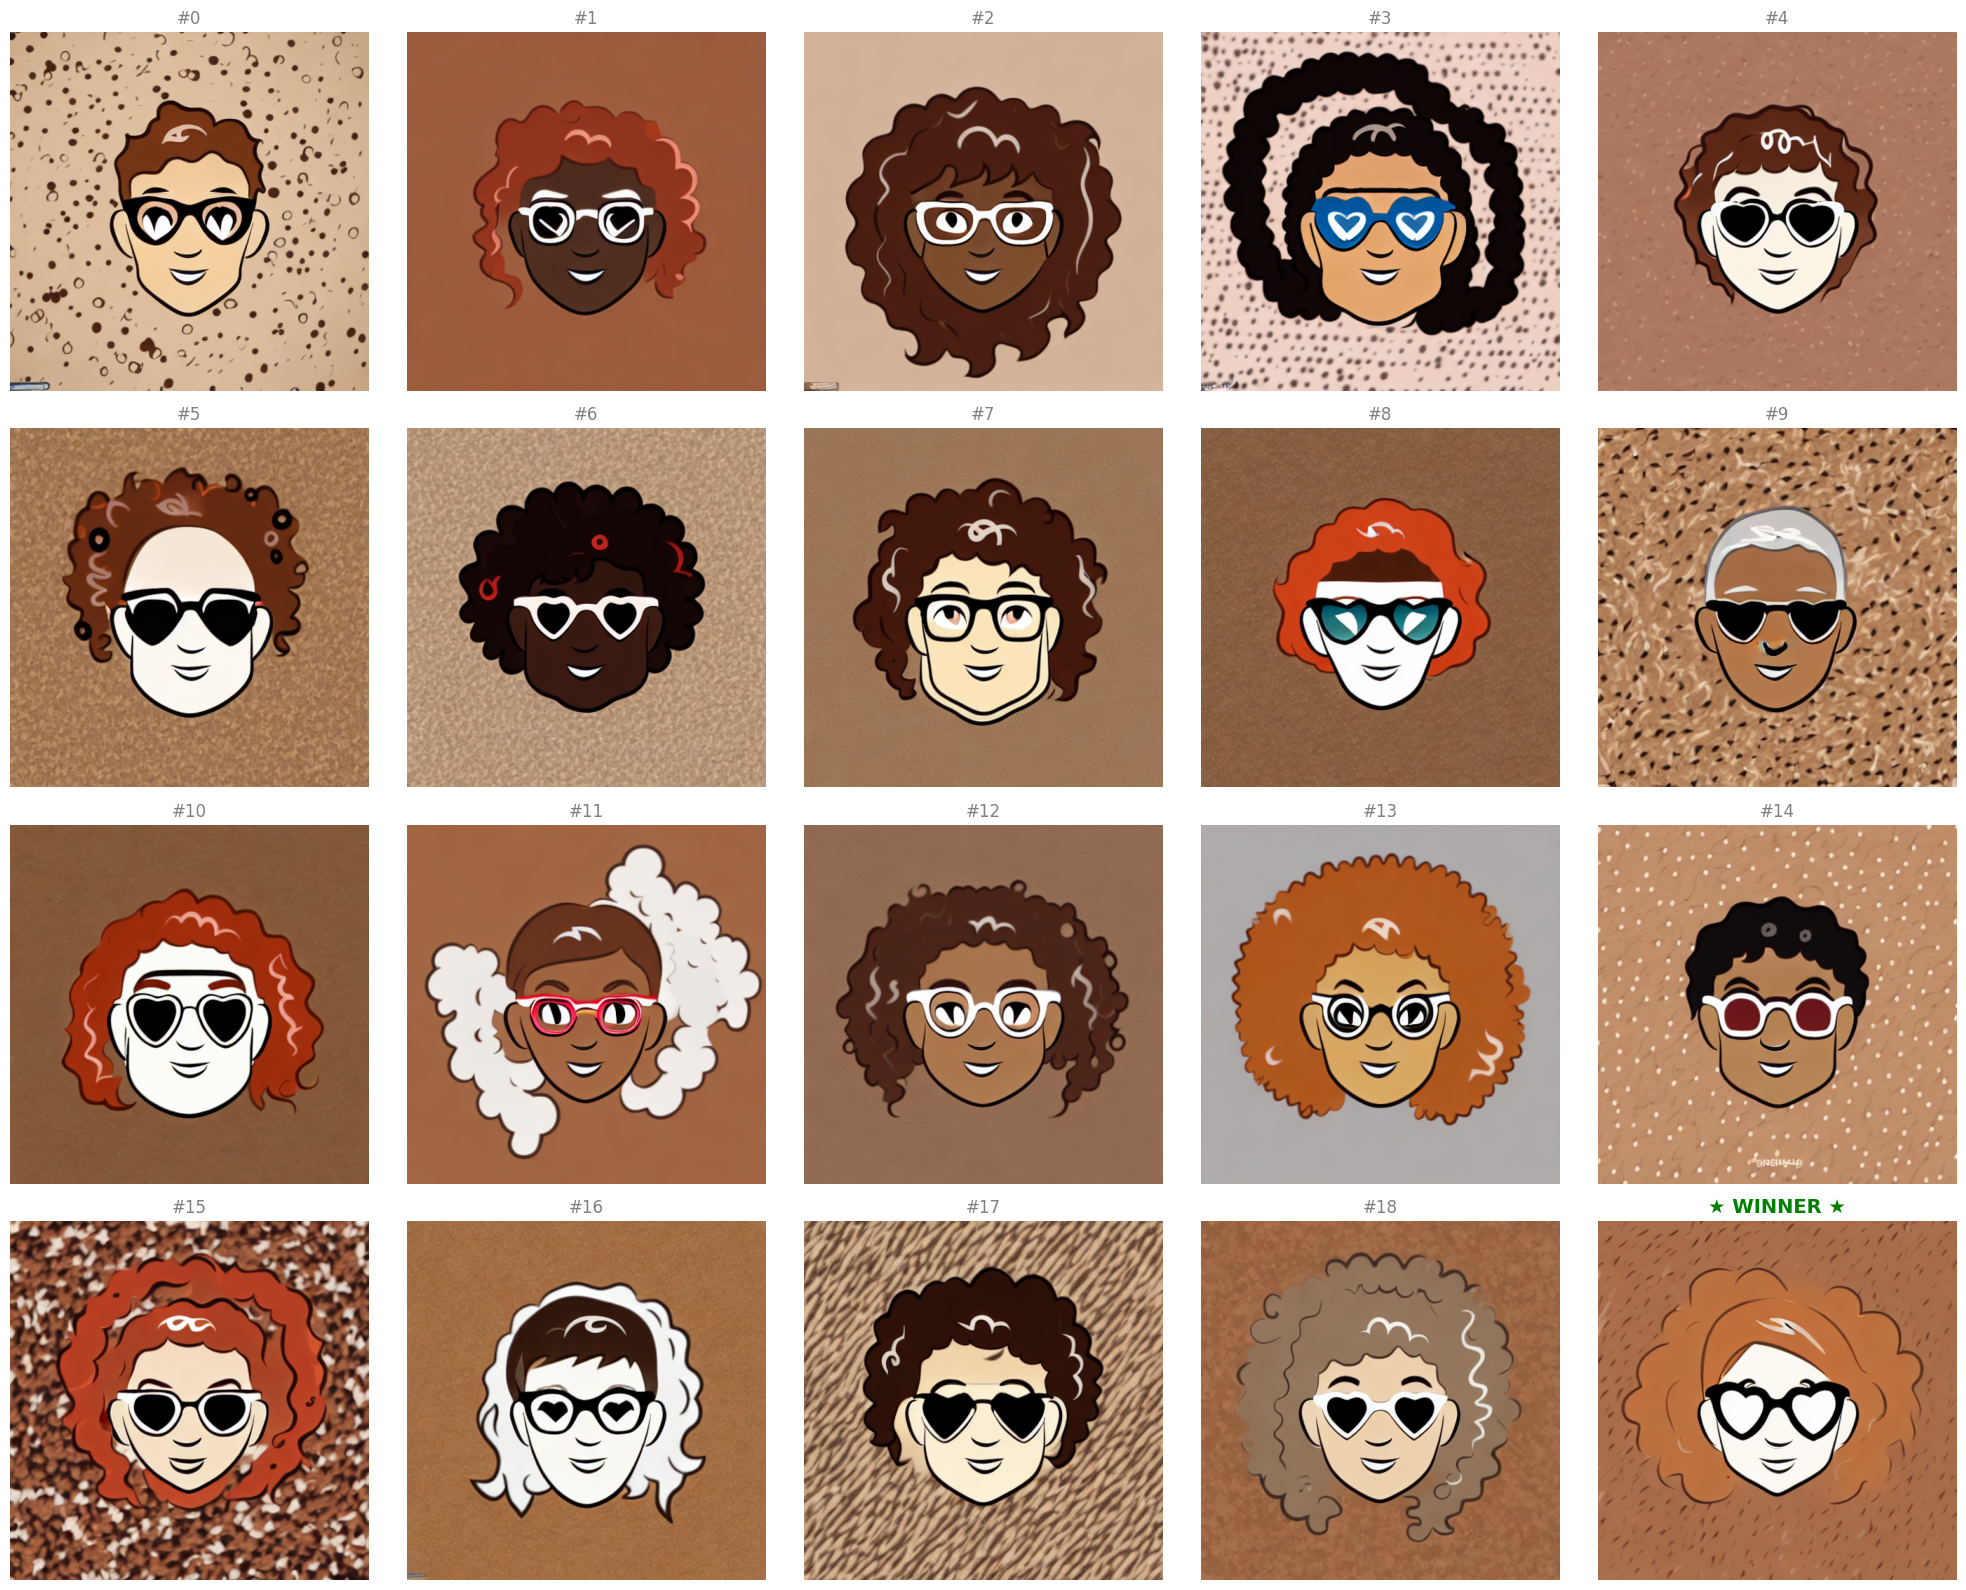


🏆 FINAL RESULT: wearing round glasses, short hair, smiling


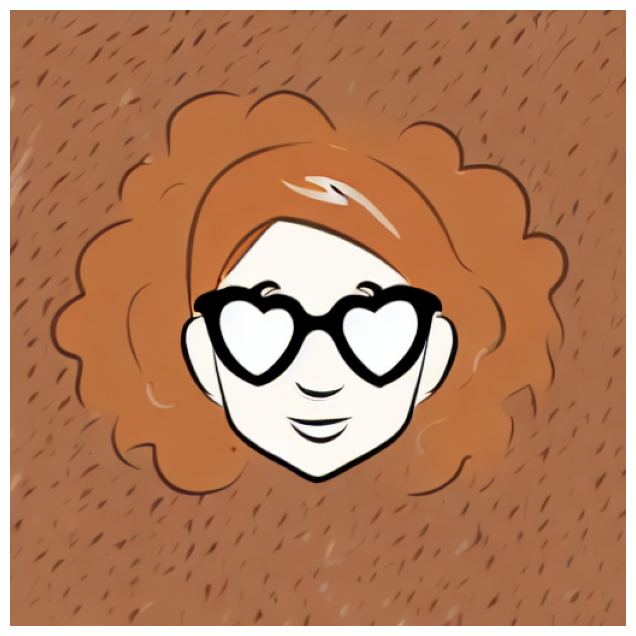

In [ ]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import re # Imported for filename cleaning

# ==========================================
# 0. SETUP: Google Drive
# ==========================================
from google.colab import drive
drive.mount('/content/drive')

# Define paths
DRIVE_ROOT = "/content/drive/MyDrive/Gen AI Project"
OUTPUT_DIR = os.path.join(DRIVE_ROOT, "best_images") # Winners go here

# Create output folder if missing
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==========================================
# 1. Load Models
# ==========================================
print("⏳ Loading CLIP model (The Judge)...")
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to("cuda")
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

print("⏳ Loading Stable Diffusion...")
# We download the base model to local Colab disk for SPEED (prevents Drive freezing)
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# Disable NSFW filter
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

print("⏳ Loading LoRA from Drive...")
pipe.load_lora_weights(
    f"{DRIVE_ROOT}/output_lora_cartoon_final/pytorch_lora_weights.safetensors",
    weight=0.5
)
print("✅ System Ready!")

# ==========================================
# 2. Configuration
# ==========================================
NEGATIVE = (
    "blue skin, yellow skin, green skin, purple skin, unnatural skin, "
    "distorted face, deformed nose, broken mouth, asymmetry, glitches, "
    "bad anatomy, wrong proportions, extra eyes, text, watermark, blurry"
)

BASE_PROMPT = (
    "simple cartoon face, natural human skin, smooth skin texture, clean outlines, "
    "correct facial proportions, cartoon style, vector art"
)

# ==========================================
# 3. Helper Functions
# ==========================================
def generate_batch(user_prompt, total_n=20):
    full_prompt = BASE_PROMPT + ", " + user_prompt
    all_images = []
    batch_size = 5

    print(f"--- Generating {total_n} candidates for: '{user_prompt}' ---")
    for i in range(0, total_n, batch_size):
        print(f"  Batch {i//batch_size + 1}...")
        batch_images = pipe(
            full_prompt,
            num_inference_steps=30,
            guidance_scale=8.0,
            negative_prompt=NEGATIVE,
            num_images_per_prompt=batch_size
        ).images
        all_images.extend(batch_images)
    return all_images

def pick_winner(candidates, specific_prompt):
    print("🤔 Judging images...")
    inputs = clip_processor(text=[specific_prompt], images=candidates, return_tensors="pt", padding=True).to("cuda")
    with torch.no_grad():
        outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image
    scores = logits_per_image.softmax(dim=0).cpu().numpy().flatten()
    best_idx = scores.argmax()
    return candidates[best_idx], best_idx

def clean_filename(text):
    # Removes special characters and spaces for a safe filename
    # e.g. "Red Hair, Green Eyes!" -> "Red_Hair_Green_Eyes"
    clean = re.sub(r'[^a-zA-Z0-9]', '_', text)
    return clean.strip('_')

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
prompt = "wearing round glasses, short hair, smiling"
N_TOTAL = 20

# A. Generate
candidates = generate_batch(prompt, total_n=N_TOTAL)

# B. Select
winner_img, winner_idx = pick_winner(candidates, prompt)

# C. Save with Prompt Name
safe_prompt = clean_filename(prompt)
timestamp = datetime.now().strftime("%H%M%S") # Short timestamp
filename = f"{safe_prompt}_{timestamp}.png"   # e.g. red_hair_green_eyes_123045.png

save_path = os.path.join(OUTPUT_DIR, filename)
winner_img.save(save_path)

print(f"💾 Saved Winner to Drive: {save_path}")

# ==========================================
# 5. DISPLAY
# ==========================================

# --- VIEW 1: All Candidates (Grid) ---
print("\n👇 All Candidates 👇")
rows = 4
cols = 5
plt.figure(figsize=(20, 16))

for i, img in enumerate(candidates):
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.axis("off")
    if i == winner_idx:
        ax.set_title("★ WINNER ★", color="green", weight="bold", fontsize=14)
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(4)
    else:
        ax.set_title(f"#{i}", color="gray")

plt.tight_layout()
plt.show()

# --- VIEW 2: The Winner (Clean) ---
print("\n" + "="*30)
print(f"🏆 FINAL RESULT: {prompt}")
print("="*30)
plt.figure(figsize=(8, 8))
plt.imshow(winner_img)
plt.axis("off")
plt.show()

# **Backend API settings**

In [ ]:
!pip install fastapi uvicorn pyngrok nest_asyncio python-multipart


In [ ]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!sudo dpkg -i cloudflared-linux-amd64.deb


--2025-11-28 11:14:54--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64.deb [following]
--2025-11-28 11:14:54--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/8a32f7c6-649c-4f0d-806d-e14c19d0786d?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-28T12%3A12%3A17Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64.deb&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4d

In [ ]:
!pip install flask flask_cors


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import base64
from io import BytesIO

app = Flask(__name__)
CORS(app)


In [ ]:
# ==========================================
# 1. IMPORTS
# ==========================================
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
import torch
import os
import re
from datetime import datetime
from google.colab import drive

# ==========================================
# 2. MOUNT GOOGLE DRIVE
# ==========================================
drive.mount('/content/drive')

DRIVE_ROOT = "/content/drive/MyDrive/Gen AI Project"
OUTPUT_DIR = os.path.join(DRIVE_ROOT, "best_images")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ==========================================
# 3. LOAD MODELS
# ==========================================
print("⏳ Loading CLIP model (The Judge)...")
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to("cuda")
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

print("⏳ Loading Stable Diffusion...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# Disable NSFW (required for API mode)
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

# Load LoRA
print("⏳ Loading LoRA from Drive...")
pipe.load_lora_weights(
    f"{DRIVE_ROOT}/output_lora_cartoon_final/pytorch_lora_weights.safetensors",
    weight=0.5
)

print("✅ Model + LoRA fully loaded!")

# ==========================================
# 4. PROMPT CONFIG
# ==========================================
NEGATIVE = (
    "dark skin, blue skin, yellow skin, green skin, purple skin, unnatural skin, "
    "distorted face, deformed nose, broken mouth, asymmetry, glitches, "
    "bad anatomy, wrong proportions, extra eyes, text, watermark, blurry"
)

BASE_PROMPT = (
    "simple cartoon face, natural human skin, smooth skin texture, clean outlines, "
    "correct facial proportions, cartoon style, vector art"
)

# ==========================================
# 5. HELPER FUNCTIONS
# ==========================================

def generate_batch(user_prompt, total_n=20):
    """
    Generates N images using Stable Diffusion + LoRA.
    """
    full_prompt = BASE_PROMPT + ", " + user_prompt
    all_images = []
    batch_size = 5

    print(f"Generating {total_n} candidates for: '{user_prompt}'")
    for i in range(0, total_n, batch_size):
        print(f"  → Batch {i//batch_size + 1}")
        batch_images = pipe(
            full_prompt,
            num_inference_steps=30,
            guidance_scale=8.0,
            negative_prompt=NEGATIVE,
            num_images_per_prompt=batch_size
        ).images
        all_images.extend(batch_images)

    return all_images


def pick_winner(candidates, specific_prompt):
    """
    Uses CLIP to pick the best image that matches the prompt.
    """
    print("🤔 Using CLIP to select best image...")
    inputs = clip_processor(
        text=[specific_prompt],
        images=candidates,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image
    scores = logits_per_image.softmax(dim=0).cpu().numpy().flatten()
    best_idx = scores.argmax()

    return candidates[best_idx], best_idx


def clean_filename(text):
    """
    Creates a safe filename from prompt text.
    """
    clean = re.sub(r'[^a-zA-Z0-9]', '_', text)
    return clean.strip('_')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Loading CLIP model (The Judge)...
⏳ Loading Stable Diffusion...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


⏳ Loading LoRA from Drive...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


✅ Model + LoRA fully loaded!


In [ ]:
import base64
from io import BytesIO
from datetime import datetime
import os

@app.route("/generate", methods=["POST"])
def generate():
    data = request.get_json()
    prompt = data["prompt"]

    # Generate + pick winner
    candidates = generate_batch(prompt, total_n=20)
    winner_img, _ = pick_winner(candidates, prompt)

    # Convert to base64 (for React)
    buffer = BytesIO()
    winner_img.save(buffer, format="PNG")
    img_str = base64.b64encode(buffer.getvalue()).decode()

    # ---------------------------------------------
    # ⭐ AUTO-SAVE TO GOOGLE DRIVE
    # ---------------------------------------------
    safe_prompt = "".join(c if c.isalnum() else "_" for c in prompt)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    filename = f"{safe_prompt}_{timestamp}.png"
    save_path = os.path.join(OUTPUT_DIR, filename)

    winner_img.save(save_path)
    print(f"💾 Saved image to Drive: {save_path}")

    return {"image": img_str, "saved_path": save_path}


In [ ]:
import threading

def run_flask():
    app.run(host="0.0.0.0", port=8000)

thread = threading.Thread(target=run_flask)
thread.start()

print("Flask server started!")


Flask server started!


In [ ]:
import subprocess
import time
import re

# Kill any previous tunnel
!pkill cloudflared 2>/dev/null

# Start cloudflare tunnel in background
process = subprocess.Popen(
    ["cloudflared", "tunnel", "--no-autoupdate", "--url", "http://localhost:8000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True
)

print("⏳ Waiting for Tunnel URL...\n")

tunnel_url = None

# Try reading 200 lines (enough to capture the tunnel always)
for i in range(200):
    line = process.stdout.readline().strip()
    print(line)  # show logs (optional)
    if "trycloudflare.com" in line:
        # Extract URL
        match = re.search(r"https:\/\/[\w\-]+\.trycloudflare\.com", line)
        if match:
            tunnel_url = match.group(0)
            break
    time.sleep(0.1)

if tunnel_url:
    print("\n⭐ Tunnel URL FOUND:")
    print(tunnel_url)
else:
    print("\n❌ Tunnel URL not found yet. Wait a few seconds and run again.")


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:8000
 * Running on http://172.28.0.12:8000
INFO:werkzeug:Press CTRL+C to quit


⏳ Waiting for Tunnel URL...

2025-11-28T11:15:42Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-28T11:15:42Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-28T11:15:44Z INF +--------------------------------------------------------------------------------------------+
2025-11-28T11:15:44Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-28T11:15:44Z INF |  https://stronger-humanit

In [ ]:
import requests

resp = requests.post(
    "https://stronger-humanities-patches-director.trycloudflare.com/generate",
    json={"prompt": "green eyes"}
)

resp.json()


ConnectionError: HTTPSConnectionPool(host='astronomy-sas-loans-finished.trycloudflare.com', port=443): Max retries exceeded with url: /generate (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x79d3a758e7e0>: Failed to resolve 'astronomy-sas-loans-finished.trycloudflare.com' ([Errno -2] Name or service not known)"))

# **Training Curves/Loss Plots**

In [ ]:
# !pip install tensorboard

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Path to your event file
event_file = "/content/drive/MyDrive/Gen AI Project/output_lora_cartoon_final/logs/text2image-fine-tune/events.out.tfevents.1764016501.30d443666a10.11601.0"

# Load event file
ea = EventAccumulator(event_file)
ea.Reload()

# List available metrics
print("Available tags:", ea.Tags())


Available tags: {'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


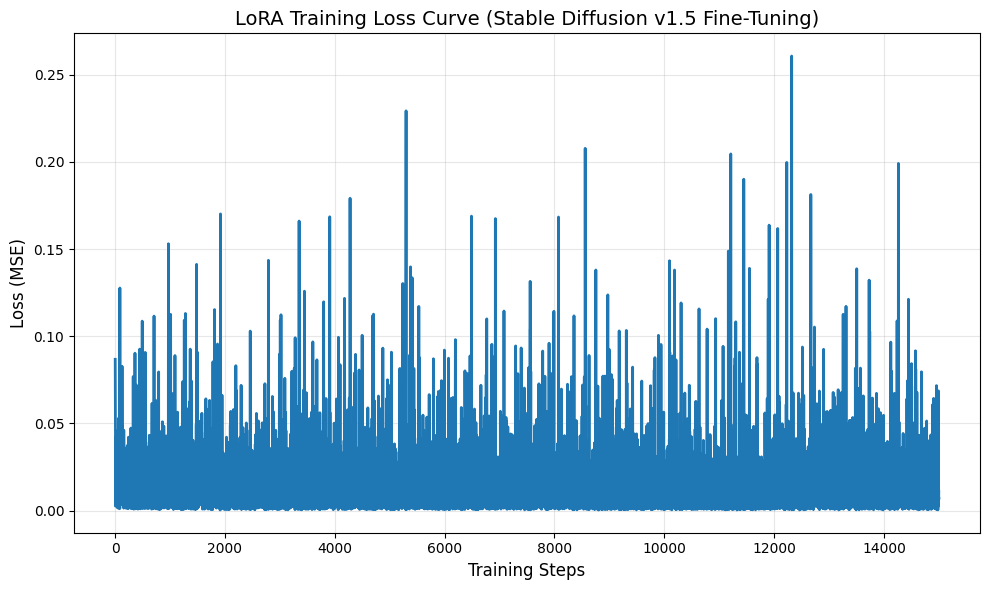

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

# Path to your event file
event_file = "/content/drive/MyDrive/Gen AI Project/output_lora_cartoon_final/logs/text2image-fine-tune/events.out.tfevents.1764016501.30d443666a10.11601.0"

# Load event file
ea = EventAccumulator(event_file)
ea.Reload()

# Extract the training loss values
loss_events = ea.Scalars("train_loss")

steps = [e.step for e in loss_events]
losses = [e.value for e in loss_events]

plt.figure(figsize=(10,6))
plt.plot(steps, losses, linewidth=2)
plt.title("LoRA Training Loss Curve (Stable Diffusion v1.5 Fine-Tuning)", fontsize=14)
plt.xlabel("Training Steps", fontsize=12)
plt.ylabel("Loss (MSE)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


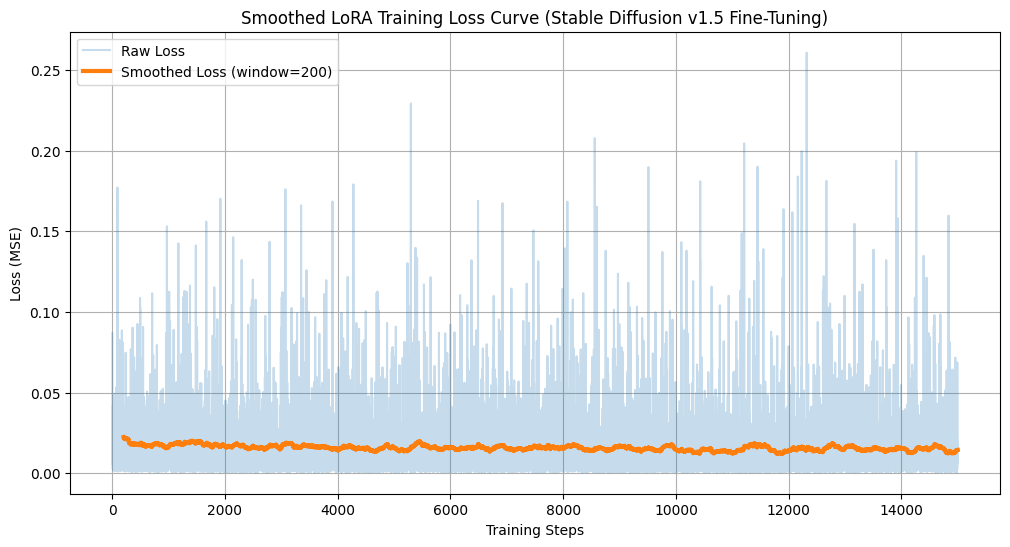

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Path provided earlier
event_path = "/content/drive/MyDrive/Gen AI Project/output_lora_cartoon_final/logs/text2image-fine-tune/events.out.tfevents.1764016501.30d443666a10.11601.0"

# Load log
ea = EventAccumulator(event_path, size_guidance={'scalars': 100000})
ea.Reload()

loss_events = ea.Scalars("train_loss")
steps = [e.step for e in loss_events]
losses = [e.value for e in loss_events]

# Moving average smoothing
window = 200
smoothed = pd.Series(losses).rolling(window=window).mean()

plt.figure(figsize=(12, 6))
plt.plot(steps, losses, alpha=0.25, label="Raw Loss")
plt.plot(steps, smoothed, linewidth=3, label=f"Smoothed Loss (window={window})")
plt.xlabel("Training Steps")
plt.ylabel("Loss (MSE)")
plt.title("Smoothed LoRA Training Loss Curve (Stable Diffusion v1.5 Fine-Tuning)")
plt.legend()
plt.grid(True)

plt.show()


# **FID**

In [ ]:
# ================================================================
# 1. IMPORTS
# ================================================================
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
import torch
import os
from google.colab import drive
from PIL import Image
from tqdm import tqdm

# ================================================================
# 2. MOUNT GOOGLE DRIVE
# ================================================================
drive.mount('/content/drive')

# ================================================================
# 3. PATHS
# ================================================================
DRIVE_ROOT = "/content/drive/MyDrive/Gen AI Project"
OUTPUT_DIR = os.path.join(DRIVE_ROOT, "best_images")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ================================================================
# 4. LOAD CLIP (not required for FID but part of your pipeline)
# ================================================================
print("⏳ Loading CLIP model...")
clip_model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_id).to("cuda")
clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

# ================================================================
# 5. LOAD STABLE DIFFUSION + LORA
# ================================================================
print("⏳ Loading Stable Diffusion...")
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

# Disable NSFW filter
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

print("⏳ Loading LoRA...")
pipe.load_lora_weights(
    f"{DRIVE_ROOT}/output_lora_cartoon_final/pytorch_lora_weights.safetensors",
    weight=0.5
)

print("✅ Model Loaded Successfully!")

# ================================================================
# 6. GENERATION PARAMETERS
# ================================================================
NEGATIVE = (
    "blue skin, yellow skin, green skin, purple skin, unnatural skin, "
    "distorted face, deformed nose, broken mouth, asymmetry, glitches, "
    "bad anatomy, wrong proportions, extra eyes, text, watermark, blurry"
)

BASE_PROMPT = (
    "simple cartoon face, natural human skin, smooth skin texture, clean outlines, "
    "correct facial proportions, cartoon style, vector art"
)

# ================================================================
# 7. FID: GENERATE 300 IMAGES
# ================================================================
GEN_DIR = "/content/drive/MyDrive/Gen AI Project/generated_fid/"
os.makedirs(GEN_DIR, exist_ok=True)

print("🔄 Generating 300 images for FID...")

user_prompt = "cartoon face"
full_prompt = BASE_PROMPT + ", " + user_prompt

missing = [1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254]

print("🔄 Generating missing FID images...")

for i in missing:
    img = pipe(
        full_prompt,
        num_inference_steps=30,
        guidance_scale=8.0,
        negative_prompt=NEGATIVE,
    ).images[0]

    img.save(os.path.join(GEN_DIR, f"gen_{i:03d}.png"))

print("✅ All missing images generated!")
print("📁 Folder is now complete (1500 images).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Loading CLIP model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


⏳ Loading Stable Diffusion...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


⏳ Loading LoRA...


No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


✅ Model Loaded Successfully!
🔄 Generating 300 images for FID...
🔄 Generating missing FID images...


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

✅ All missing images generated!
📁 Folder is now complete (1500 images).


# **FID Score**

In [ ]:
# ============================================================
# 1. IMPORTS
# ============================================================
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm import tqdm
import torch_fidelity

# ============================================================
# 2. PATHS
# ============================================================
REAL_DIR = "/content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500/"
GEN_DIR  = "/content/drive/MyDrive/Gen AI Project/generated_fid/"

# ============================================================
# 3. RUN FID WITH TORCH-FIDELITY
# ============================================================
print("🔍 Running FID on 1500 Real vs 1500 Generated Images...\n")

fid_score = torch_fidelity.calculate_metrics(
    input1=REAL_DIR,
    input2=GEN_DIR,
    cuda=True,
    isc=False,           # Inception Score not needed
    fid=True,            # Enable FID
    kid=False,           # Kernel Inception Distance (optional)
    verbose=True
)

print("\n========================================")
print("🎯 FINAL FID SCORE (1500 samples):", fid_score["frechet_inception_distance"])
print("========================================")


🔍 Running FID on 1500 Real vs 1500 Generated Images...



Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 308MB/s]
Extracting statistics from input 1
Looking for samples non-recursivelty in "/content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500/" with extensions png,jpg,jpeg
Found 1500 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
/usr/local/lib/python3.12/dist-pa


🎯 FINAL FID SCORE (1500 samples): 126.06108800321041


Frechet Inception Distance: 126.06108800321041


In [ ]:
!pip install torchmetrics[image]
!pip install torch-fidelity


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.1 MB/s eta 0:00:00


# **CMMD Evaluation better than FID**

In [ ]:
import os
import torch
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F

REAL_DIR = "/content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500/"
GEN_DIR  = "/content/drive/MyDrive/Gen AI Project/generated_fid/"

def get_clip_embeddings(folder):
    embeddings = []

    files = sorted([f for f in os.listdir(folder) if f.endswith(".png")])[:1500]

    for fname in tqdm(files, desc=f"Embedding {folder}"):
        img = Image.open(os.path.join(folder, fname)).convert("RGB")

        inputs = clip_processor(images=img, return_tensors="pt").to("cuda")

        with torch.no_grad():
            emb = clip_model.get_image_features(**inputs)
            emb = F.normalize(emb, p=2, dim=-1)

        embeddings.append(emb.cpu().numpy())

    return np.vstack(embeddings)

real_emb = get_clip_embeddings(REAL_DIR)
gen_emb  = get_clip_embeddings(GEN_DIR)

def gaussian_kernel(x, y, sigma=1.0):
    x = x[:, None, :]
    y = y[None, :, :]
    dist = ((x - y)**2).sum(axis=2)
    return np.exp(-dist / (2 * sigma**2))

def mmd(x, y, sigma=1.0):
    Kxx = gaussian_kernel(x, x, sigma)
    Kyy = gaussian_kernel(y, y, sigma)
    Kxy = gaussian_kernel(x, y, sigma)

    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()

cmmd_score = mmd(real_emb, gen_emb, sigma=1.0)

print("========================================")
print("🎯 FINAL CMMD SCORE:", cmmd_score)
print("========================================")


Embedding /content/drive/MyDrive/Gen AI Project/cartoonset_captioned_1500/: 100%|██████████| 1500/1500 [01:04<00:00, 23.22it/s]
Embedding /content/drive/MyDrive/Gen AI Project/generated_fid/: 100%|██████████| 1500/1500 [01:02<00:00, 24.09it/s]


🎯 FINAL CMMD SCORE: 0.15730393
